In [1]:
from pyspark.sql import SparkSession

#Crear una sesión de Spark
spark = (SparkSession.builder
    .appName('K-Means Escalable')
    .master("local[*]")
    .getOrCreate())

spark.sparkContext.setLogLevel('WARN')
print("Spark: "+spark.version)

Spark: 3.5.1


Load Dataset

In [2]:
import kagglehub
path = kagglehub.dataset_download("fellahabdelnour13/articles-classification-dataset")

Using Colab cache for faster access to the 'articles-classification-dataset' dataset.


In [16]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, DateType

schema = StructType([
    StructField("id", StringType()),
    StructField("title", StringType()),
    StructField("abstract", StringType()),
    StructField("keywords", ArrayType(StringType())),
    StructField("authors", ArrayType(StringType())),
    StructField("venue", ArrayType(StringType())),
    StructField("date", DateType()),
    StructField("teams", ArrayType(StringType()))
])

df = spark.read.option("multiline", "true").schema(schema).json(path)
df.show(10)

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+
|     id|               title|            abstract|            keywords|             authors|               venue|      date|      teams|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+
|5096000|Diffusion-based s...|Third octave spec...|[speech privacy, ...|[Modan Tailleur, ...|      [info.info-ai]|2025-09-08|[AAU, LS2N]|
|5113219|Ambiances. A Sens...|How do ambiances ...|[ambiance, atmosp...|[Jean-Paul Thibau...|[shs.archi, sde.e...|2025-09-08|      [AAU]|
|5129109|Sensory Urban Mob...|Beyond documentin...|[mobilité urbaine...|     [Damien Masson]|         [shs.archi]|2025-07-01|      [AAU]|
|5129157|Preprint_Extended...|As much as a symb...|[ambiances, criti...|     [Rachel Thomas]|               [shs]|2025-05-11|      [AAU]|
|5116799|Comparison of GNS...|The 

In [17]:
df = df.select('title', 'abstract').take(100)
rdd = spark.sparkContext.parallelize(df)
rdd_combined = rdd.map(lambda row: (row[0] or '') + ' ' + (row[1] or ''))

#Preprocesamiento

In [5]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

# Broadcast solo para stopwords
sr = set(stopwords.words('english'))
sr_bc = spark.sparkContext.broadcast(sr)

# Inicializar recursos para cada particion
def init_resources():
  stemmer = SnowballStemmer('english')
  return stemmer

# Limpiar textos de cada fila
def clean_partitions(iterator):
  stemmer = init_resources()
  sr = sr_bc.value
  for text in iterator:
    if not isinstance(text, str) or text.strip() == "":
      yield []
      continue
    tokens = re.findall(r'\b[a-z]+\b', text.lower())# Minusculas
    tokens = [word for word in tokens if word not in sr]  # Stopwords
    tokens = [stemmer.stem(word) for word in tokens]   # Reduccion a raiz
    yield tokens

In [22]:
rdd_clean = rdd_combined.mapPartitions(clean_partitions)

In [23]:
rdd_clean.take(1)

[['diffus',
  'base',
  'spectral',
  'super',
  'resolut',
  'third',
  'octav',
  'acoust',
  'sensor',
  'data',
  'privaci',
  'risk',
  'third',
  'octav',
  'spectral',
  'record',
  'acoust',
  'sensor',
  'data',
  'effect',
  'way',
  'measur',
  'environ',
  'strong',
  'evid',
  'slow',
  'frame',
  'hz',
  'rate',
  'fast',
  'frame',
  'rate',
  'version',
  'lead',
  'design',
  'unintellig',
  'speech',
  'reconstruct',
  'advent',
  'high',
  'qualiti',
  'reconstruct',
  'method',
  'base',
  'diffus',
  'may',
  'pose',
  'threat',
  'approach',
  'emb',
  'signific',
  'amount',
  'priori',
  'knowledg',
  'learn',
  'extens',
  'speech',
  'dataset',
  'p',
  'paper',
  'aim',
  'assess',
  'risk',
  'three',
  'level',
  'attack',
  'grow',
  'level',
  'priori',
  'knowledg',
  'consid',
  'learn',
  'diffus',
  'model',
  'none',
  'b',
  'multi',
  'speaker',
  'data',
  'exclud',
  'target',
  'speaker',
  'c',
  'target',
  'speaker',
  'without',
  'prior',
 

Transformar texto IDF-TF
---



In [25]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF

tf = HashingTF(numFeatures=2000)
rdd_vectors = rdd_clean.map(lambda tokens: tf.transform(tokens))

idf_model = IDF().fit(rdd_vectors)
rdd_tfidf = idf_model.transform(rdd_vectors)

print(rdd_tfidf.take(1))

[SparseVector(2000, {78: 2.3125, 111: 2.5357, 155: 1.357, 156: 1.7247, 162: 3.2288, 176: 3.2288, 215: 2.0502, 236: 2.6692, 252: 2.3125, 278: 3.2288, 281: 2.2172, 289: 10.5495, 310: 3.922, 313: 15.6879, 331: 3.0057, 336: 2.0502, 395: 3.0057, 408: 1.1494, 450: 5.9282, 453: 3.2288, 502: 2.2172, 528: 2.4179, 535: 2.1302, 578: 3.5165, 585: 1.9071, 586: 1.2829, 643: 4.1003, 667: 2.2172, 723: 4.2604, 726: 4.6251, 739: 2.6692, 740: 6.9376, 746: 2.5357, 781: 1.7247, 798: 3.2288, 818: 5.9282, 843: 4.6251, 876: 3.2288, 898: 3.9521, 951: 3.0057, 972: 3.2288, 979: 3.2288, 982: 1.7247, 1012: 1.5241, 1104: 1.2139, 1129: 3.2288, 1141: 10.5495, 1162: 0.7865, 1219: 2.0502, 1220: 5.6467, 1283: 1.5241, 1342: 1.7819, 1422: 6.4577, 1423: 3.2288, 1444: 2.4179, 1451: 0.8309, 1544: 5.3384, 1559: 4.4389, 1574: 1.0316, 1609: 3.922, 1624: 1.4371, 1625: 0.8539, 1650: 1.9761, 1658: 4.7118, 1678: 2.8234, 1689: 5.6467, 1705: 4.4345, 1710: 2.3125, 1764: 1.6194, 1768: 6.0114, 1778: 2.4179, 1832: 1.1186, 1926: 2.3623, 1

#K-Means++ Escalable

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import random
import math

In [27]:
#Distancia euclidiana
def dist2(x, y):
    return sum((a - b) ** 2 for a, b in zip(x, y))

#Costo φX(C): suma de distancias al centro más cercano
def phi_X_C(points_rdd, centers):
    return points_rdd.map(
        lambda x: min(dist2(x, c) for c in centers)
    ).sum()

#Probabilidad de muestreo px
def sample_points(points_rdd, centers, phi, l):
    return points_rdd.flatMap(
        lambda x: [x] if random.random() < (l * min(dist2(x, c) for c in centers)) / phi else []
    )

#K-means++
def kmeans_pp_weighted(weighted_centers, k):
    centers = []

    # Tomar un centro inicial aleatorio
    c0 = random.choice(weighted_centers)[0]
    centers.append(c0)

    while len(centers) < k:
        distances = []

        # Distancia ponderada al centro más cercano
        for (c, w) in weighted_centers:
            d2 = min(dist2(c, ci) for ci in centers)
            distances.append((c, w * d2))

        total = sum(wd for (c, wd) in distances)

        # Selección por ruleta ponderada
        r = random.random() * total
        cumulative = 0

        for (c, wd) in distances:
            cumulative += wd
            if cumulative >= r:
                centers.append(c)
                break

    return centers

In [28]:
def kmeans_escalable(points_rdd, k, l=None):
    if l is None:
        l = 2 * k

    # 1. Elegir un punto aleatorio como primer centro
    first_center = points_rdd.takeSample(False, 1)[0]
    centers = [first_center]

    # 2. Calcular phi inicial
    phi = phi_X_C(points_rdd, centers)

    # 3. Número de rondas ≈ O(log(phi))
    rounds = int(math.log(phi + 1))

    for _ in range(rounds):
        # 4. Muestreo independiente con prob px
        new_centers = sample_points(points_rdd, centers, phi, l).collect()

        # 5. Agregar los candidatos
        centers.extend(new_centers)

        # 6. Recalcular el costo
        phi = phi_X_C(points_rdd, centers)

    # 7. Calcular pesos w_x para cada centro candidato "número de puntos más cercanos"
    weighted = (
        points_rdd
        .map(lambda x: (min(centers, key=lambda c: dist2(x, c)), 1))
        .reduceByKey(lambda a, b: a + b)
    )

    weighted_centers = weighted.collect()  # (center, weight)

    # 8. Reclustering final sobre los candidatos (k-means++ simple)
    final_centers = kmeans_pp_weighted(weighted_centers, k)

    return final_centers

In [29]:
k = 3
final_centers = kmeans_escalable(rdd_tfidf, k)

print("Centros finales:")
for c in final_centers:
    print(c)

Centros finales:
(2000,[22,25,50,53,82,90,99,103,115,119,124,142,145,158,163,179,193,222,228,248,254,267,272,279,290,306,311,325,330,343,347,350,356,374,401,417,422,435,439,449,452,455,465,494,501,503,512,530,531,539,557,561,573,614,642,652,678,679,687,688,695,705,714,723,724,734,741,766,773,785,794,817,822,833,856,863,866,873,890,892,899,924,957,960,965,984,986,988,989,999,1005,1018,1028,1032,1036,1041,1058,1059,1091,1101,1108,1116,1123,1125,1128,1131,1144,1152,1154,1188,1189,1193,1196,1203,1209,1242,1244,1260,1277,1280,1296,1299,1303,1315,1319,1336,1344,1347,1348,1360,1370,1372,1386,1397,1411,1413,1414,1428,1434,1436,1439,1441,1443,1452,1493,1504,1516,1520,1546,1595,1598,1607,1610,1617,1637,1646,1655,1671,1673,1676,1680,1697,1698,1701,1710,1726,1727,1738,1744,1745,1747,1756,1760,1761,1782,1808,1820,1834,1858,1868,1869,1872,1873,1885,1909,1919,1935,1938,1947,1954,1962],[3.005682604407159,2.6692103677859462,2.8233610476132043,10.549524684519449,6.011365208814318,8.007631103357838,4.434

Visualizar Resultados

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, DenseVector, SparseVector

def vector_to_array(v):
    # Convierte SparseVector o DenseVector a numpy array
    if isinstance(v, (SparseVector, DenseVector)):
        return np.array(v.toArray())
    else:
        return np.array(v)

# Convertir RDD de numpy arrays a DataFrame con columna "features"
df_features = rdd_tfidf.map(lambda x: (Vectors.dense(vector_to_array(x)), )).toDF(["features"])

# PCA a 2 componentes
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_features)
df_pca = pca_model.transform(df_features)

# Convertir a lista para matplotlib
pca_points = np.array(df_pca.select("pca_features").rdd.map(lambda row: row[0]).collect())

# Asignación usando tus centroides originales
cluster_assignments = rdd_tfidf.map(lambda v: assign_cluster(v, final_centers)).collect()
cluster_assignments = np.array(cluster_assignments)

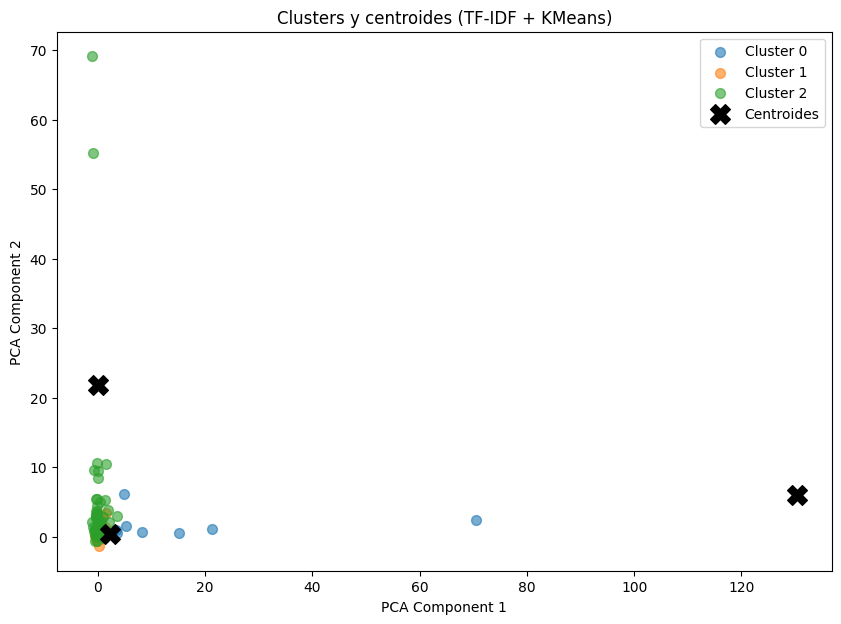

In [45]:
import matplotlib.pyplot as plt

# Graficar puntos por cluster
k = len(final_centers)
colors = plt.colormaps['tab10']
plt.figure(figsize=(10,7))

for cluster_id in range(k):
    idx = cluster_assignments == cluster_id
    plt.scatter(pca_points[idx, 0], pca_points[idx, 1],
                s=50, alpha=0.6,
                color=colors(cluster_id),
                label=f"Cluster {cluster_id}")

# Graficar centroides en PCA
centers_array = np.array([vector_to_array(c) for c in final_centers])
centers_2d = np.array([
    pca_model.transform(
        spark.createDataFrame([(Vectors.dense(c),)], ["features"])
    ).select("pca_features").first()[0]
    for c in centers_array
])
plt.scatter(centers_2d[:,0], centers_2d[:,1], c='black', marker='X', s=200, label='Centroides')

# Detalles de la gráfica
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters y centroides (TF-IDF + KMeans)")
plt.legend()
plt.show()

#Evaluar Modelo Silhouette

In [30]:
import numpy as np

# Distancia coseno
def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)

# Asignar cluster más cercano
def assign_cluster(vector, centers):
    distances = [cosine_distance(vector, c) for c in centers]
    return int(np.argmin(distances))

# Función Silhouette
def silhouette_score_rdd(rdd_vectors, centers):
    # 1. Asignar cada vector a su cluster
    rdd_clustered = rdd_vectors.map(lambda v: (v, assign_cluster(v, centers)))

    # 2. Agrupar puntos por cluster (para a(i) y b(i))
    clusters = (rdd_clustered.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list).collectAsMap())

    # a(i): intracluster
    def a_i(v, Ci):
        points = clusters[Ci]
        if len(points) == 1:
            return 0.0
        return np.mean([cosine_distance(v, x)
                        for x in points if not np.all(v == x)])

    # b(i): intercluster
    def b_i(v, Ci):
        return min([
            np.mean([cosine_distance(v, x) for x in clusters[c]])
            for c in clusters if c != Ci
        ])

    # s(i)
    def silhouette_point(v, Ci):
        ai = a_i(v, Ci)
        bi = b_i(v, Ci)
        return (bi - ai) / max(ai, bi)

    # Lista de (cluster, s(i))
    silhouette_list = rdd_clustered.map(
        lambda x: (x[1], float(silhouette_point(x[0], x[1])))
    ).collect()

    # Silhouette total (promedio)
    silhouette_rdd = rdd_clustered.map(lambda x: silhouette_point(x[0], x[1]))
    S = silhouette_rdd.mean()

    return S, silhouette_list

In [36]:
sample = rdd_tfidf.sample(False, 0.1, seed=42).collect()  # 10% de los datos
sampled_rdd = spark.sparkContext.parallelize(sample)

S, silhouette_list = silhouette_score_rdd(rdd_tfidf, final_centers)
print("Silhouette promedio:", S)

Silhouette promedio: 0.022713361492594966


Visualizar Resultados

In [37]:
import matplotlib.pyplot as plt

def plot_silhouette(silhouette_list, S):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Ordenar por cluster
    silhouette_list_sorted = sorted(silhouette_list, key=lambda x: x[0])

    clusters = sorted(set([c for c, _ in silhouette_list]))

    y_lower = 0
    for cluster_id in clusters:
        # valores del cluster actual
        cluster_sil = [s for (c, s) in silhouette_list_sorted if c == cluster_id]
        cluster_sil.sort()

        size = len(cluster_sil)
        y_upper = y_lower + size

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil,
            alpha=0.6,
            label=f"Cluster {cluster_id}"
        )

        y_lower = y_upper

    # Línea del Silhouette promedio
    ax.axvline(S, color="red", linestyle="--", label=f"Silhouette = {S:.3f}")

    ax.set_xlabel("Coeficiente Silhouette")
    ax.set_ylabel("Puntos")
    ax.set_title("Silhouette Plot")
    ax.legend()

    plt.show()

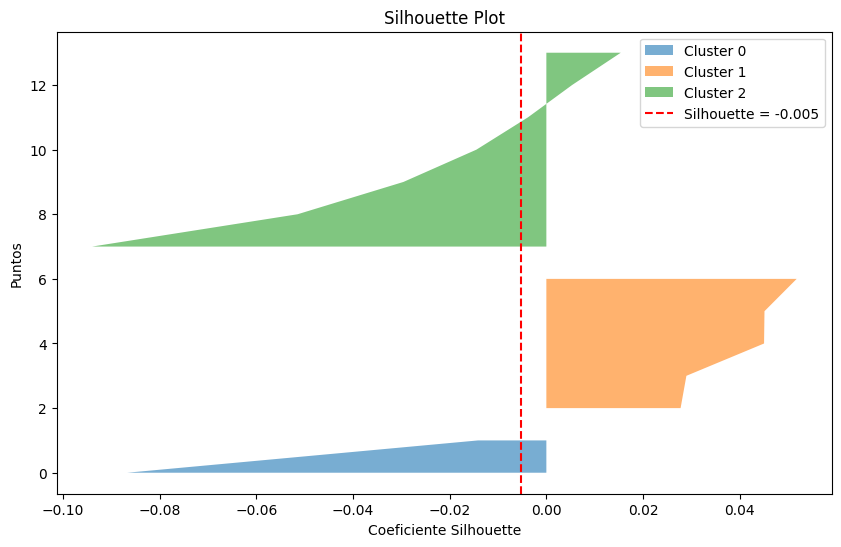

In [35]:
plot_silhouette(silhouette_list, S)

#K-Means SparkML

In [52]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol='features', k=k, seed=42)
model = kmeans.fit(df_features)

# Obtener centros
centers = model.clusterCenters()
print("Centroides finales:")
for c in centers:
    print(c)

Centroides finales:
[0.         0.08004027 0.         ... 0.38131577 0.15335115 0.04002014]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [48]:
#Asignar clusters a los puntos
df_clusters = model.transform(df_features)
df_clusters.select("features", "prediction").show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.0,0.0,0.0,0.0,...|         0|
|[0.0,0.0,0.0,0.0,...|         0|
|[0.0,0.0,0.0,0.0,...|         0|
|[0.0,0.0,0.0,0.0,...|         0|
|[0.0,0.0,0.0,0.0,...|         0|
+--------------------+----------+
only showing top 5 rows



In [49]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="cosine")
silhouette = evaluator.evaluate(df_clusters)
print("Silhouette promedio:", silhouette)

Silhouette promedio: -0.02315828657218514


Visualizar resultados

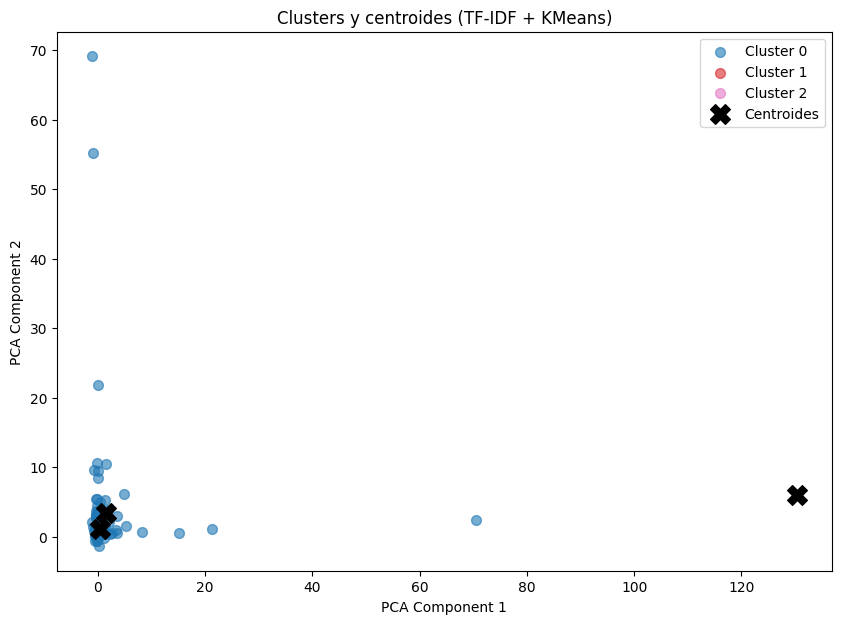

In [54]:
import matplotlib.pyplot as plt

pca = PCA(k=k, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_features)
df_pca = pca_model.transform(df_features)

pca_points = np.array(df_pca.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect())
cluster_assignments = np.array(df_clusters.select("prediction").rdd.map(lambda row: row[0]).collect())

colors = plt.colormaps['tab10']
plt.figure(figsize=(10,7))

for cluster_id in range(k):
    idx = cluster_assignments == cluster_id
    plt.scatter(pca_points[idx, 0], pca_points[idx, 1],
                s=50, alpha=0.6,
                color=colors(cluster_id / k),
                label=f"Cluster {cluster_id}")

# Centroides en PCA
centers_2d = np.array([
    pca_model.transform(
        spark.createDataFrame([(Vectors.dense(c),)], ["features"])
    ).select("pca_features").first()[0]
    for c in centers
])
plt.scatter(centers_2d[:,0], centers_2d[:,1], c='black', marker='X', s=200, label='Centroides')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters y centroides (TF-IDF + KMeans)")
plt.legend()
plt.show()